In [65]:
import tensorflow as tf
import qriemannopt as qro
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

### Auxiliary function

In [66]:
def kron(A, B):
    """
    Returns kronecker product of two square matrices.
    Args:
        A: complex valued tf tensor of shape (dim1, dim1)
        B: complex valued tf tensor of shape (dim2, dim2)
    Returns:
        complex valued tf tensor of shape (dim1 * dim2, dim1 * dim2),
        kronecker product of matrices
    """
    
    dim1 = A.shape[-1]
    dim2 = B.shape[-1]
    AB = tf.transpose(tf.tensordot(A, B, axes=0), (0, 2, 1, 3))
    return tf.reshape(AB, (dim1 * dim2, dim1 * dim2))

### Random target gate, length of trained gate and initial random values for one qubit gates

In [70]:
# length of decomposition
circuit_length = 4

# cnot gate
cnot = tf.constant([[1, 0, 0, 0],
                    [0, 1, 0, 0],
                    [0, 0, 0, 1],
                    [0, 0, 1, 0]], dtype=tf.complex128)

# unitary gate, one wants to decompose
target_U = qro.manifold.real_to_complex(tf.random.normal((4, 4, 2), dtype=tf.float64))
target_U, _ = tf.linalg.qr(target_U)

# initial one qubit gates
u_1 = [tf.linalg.qr(qro.manifold.real_to_complex(tf.random.normal((2, 2, 2),
                                                                  dtype=tf.float64)))[0] for _ in range(circuit_length)]
u_2 = [tf.linalg.qr(qro.manifold.real_to_complex(tf.random.normal((2, 2, 2),
                                                                  dtype=tf.float64)))[0] for _ in range(circuit_length)]
u_1 = list(map(qro.manifold.complex_to_real, u_1))
u_2 = list(map(qro.manifold.complex_to_real, u_2))

### Optimization loop

In [71]:
#================================#
iters = 500 # number of iterations
lr = 0.2 # learning rate
#================================#

# optimizer
m = qro.manifold.StiefelManifold()
opt = qro.optimizers.RAdam(m, lr, ams=True)

# turn one qubit gates to tf variables
varu_1 = list(map(tf.Variable, u_1))
varu_2 = list(map(tf.Variable, u_2))

errs = [] # will be filled by err vs iter

for _ in range(iters):
    with tf.GradientTape() as tape:
        # from real to complex
        varu_1c = list(map(qro.manifold.real_to_complex, varu_1))
        varu_2c = list(map(qro.manifold.real_to_complex, varu_2))

        # computing of gate
        gate = kron(varu_1c[0], varu_2c[0])
        for i in range(1, len(varu_1c)):
            gate = cnot @ gate
            gate = kron(varu_1c[i], varu_2c[i]) @ gate

        # frobenius square distance
        d = gate - target_U
        loss = tf.linalg.trace(d @ tf.linalg.adjoint(d))
        
    errs.append(tf.math.sqrt(loss))
    grad = tape.gradient(loss, varu_1 + varu_2)
    opt.apply_gradients(zip(grad, varu_1 + varu_2))

### Plotting

[0, 0] element of trained gate (-0.39315166362154924+0.0860722984065988j)
[0, 0] element of target gate (-0.3931516636208958+0.08607229840779103j)


C:\Users\HYPERPC\Anaconda3\lib\site-packages\tensorflow_core\python\framework\ops.py:859: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())
C:\Users\HYPERPC\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'err')

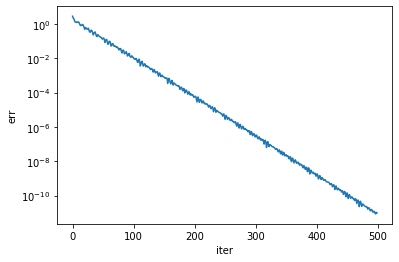

In [72]:
print('[0, 0] element of trained gate', gate[0, 0].numpy())
print('[0, 0] element of target gate', target_U[0, 0].numpy())
plt.plot(errs)
plt.yscale('log')
plt.xlabel('iter')
plt.ylabel('err')